https://institutefordiseasemodeling.github.io/Documentation/general/model-overview.html

Coursera: https://www.coursera.org/learn/epidemics

- $\beta =$ infectiousness of disease.

- $\gamma = 1/D$ where $D$ is the average duration of infection.


SI:
Once infected, stay infected forever. Infinite duration of infection, i.e. $\gamma = 0$, no healing. Like herpes.

SIS:
Once infected, can heal and become susceptible again. $\gamma > 0$. Like common cold.

SIR:
Immune after recovery, like chicken-pox.


- Death after certain time of fully having the disease, dict of runs with disease
- Different resistences per person, dict resistence, affects rate beta

In [1]:
import networkx as nx
import numpy as np
from random import sample

import matplotlib.pyplot as plt
plt.set_cmap('Reds')
from matplotlib.colors import rgb2hex

### Random network generator

In [2]:
# The adjacency matrix (float full matrix)
def adj_mat(g):
    """Returns a dense adjacency matrix for a graph g"""
    return np.array(nx.adjacency_matrix(g).todense(), dtype=np.float64)

# randoms
from numpy.random import rand, choice

def random_adjmat(n, p=0.5):
    """Returns a graph where each edge appears with probability p"""
    X = rand(n, n)
    X[X < np.sqrt(1 - p)] = 0
    X[np.logical_or(X > 0, X.T > 0)] = 1
    np.fill_diagonal(X, 0)
    return X

def random_network(n, p=0.5):
    """Returns a networkx graph with n vertices where each edge 
    appears with probability p"""
    return nx.from_numpy_array(random_adjmat(n, p))

### Draw netwrok

In [3]:
def draw_network(g, pos=None, title=None):
    # create colourmap from the spins
    #cmap = [infection for node,infection in nx.get_node_attributes(g, 'infection').items()]
    
    n = len(g)
    colouring = []
    reds = plt.get_cmap('Reds')
    
    for i in range(n):
        
        node = g.nodes[i]
        
        if node['life_state'] == 0:
            colour = '#808080' #grey
        else:
            colour = rgb2hex(reds(node['infection']*0.99)[:3])
        
        colouring.append(colour)

    # creating positions for drawing
    if type(pos) == tuple:
        n,m = pos
        pos = {node: (node//n,node%n) for node in g.nodes}
    
    nx.draw_networkx_nodes(g,pos,node_color=colouring,vmin=0,vmax=1,node_size=75)
    edgelist = [edge for edge in g.edges]
    nx.draw_networkx_edges(g, pos, edgelist,width=0.5)

    # if a title is supplied, add it to the plot
    if title:
        plt.title(title)
        
    plt.axis('off')

### Modelling

In [4]:
def update_node(old_infection,m,beta,duration,sus):
    
    new_node_infection = old_infection + sus*beta*m - 1/duration
        
    if new_node_infection < 0:
        new_node_infection = 0
    elif new_node_infection > 1:
        new_node_infection = 1
        
    return new_node_infection

In [5]:
# now nodes also have round_diseased attr, life_state attribute, susceptibility attr

# returns updated update_network after 1 run
def update_network(g, beta:float, duration:float, lethality=1):

    for node in g.nodes:
        
        # if dead, skip
        if g.nodes[node]['life_state'] == 0:
            continue
        
        neighbors = g.neighbors(node)
        neighbor_infections = [g.nodes[i]['infection'] for i in neighbors]
        m = sum(neighbor_infections)
    
        
        # check if node should die
        if g.nodes[node]['rounds_diseased'] > lethality:
            g.nodes[node]['life_state'] = 0 # kill it
            g.nodes[node]['infection'] = 0 # is dead, cannot infect others
            
        else:
            # calculate new infection
            sus = g.nodes[node]['susceptibility']
            old_infection = g.nodes[node]['infection']
            new_infection = update_node(old_infection,m,beta,duration,sus)
            g.nodes[node]['infection'] = new_infection
            
            if new_infection > 0:
                g.nodes[node]['rounds_diseased'] += 1
            else: 
                # continue as healed or reset the disease clock for this person. 
                # If diseased before, they are now healed...Implement......
                g.nodes[node]['rounds_diseased'] = 0
    
    return g

In [6]:
def g_init(g,sus_dict=None,init_infect=1):
    
    n = len(g)
    ones = {i:1 for i in range(n)}
    zeros = {i:0 for i in range(n)}
    
    if sus_dict is None:
        sus_dict = ones.copy()
    
    life_state_dict = ones.copy()
    rounds_diseased_dict = zeros.copy()
    
    # if only number to be infected is given, choose randoms to infect
    if type(init_infect) is int:
        init_infect_dict = zeros.copy()
        infect_indices = sample(range(n),init_infect)
        for i in infect_indices:
            init_infect_dict[i] = 1
    
    nx.set_node_attributes(g,init_infect_dict,'infection')
    nx.set_node_attributes(g,sus_dict,'susceptibility')
    nx.set_node_attributes(g,life_state_dict,'life_state')
    nx.set_node_attributes(g,rounds_diseased_dict,'rounds_diseased')
    
    return g

In [26]:
def run_sim(g,beta,duration,n_rounds,lethality=3,init_infect=1,sus_dict=None):
    
    pos = nx.spring_layout(g)
    
    g = g_init(g,sus_dict,init_infect)

    # initiate simulation
    draw_network(g,pos,'Initial')
    plt.show()

    for run in range(n_runs):

        infections = sum(nx.get_node_attributes(g,'infection').values())
        if infections == 0:
            break
            
        g = update_network(g,beta,duration,lethality)
        draw_network(g,pos,'Run '+str(run+1))
        plt.show()

### Test

Types of graphs:  
https://networkx.github.io/documentation/networkx-1.10/reference/generators.html

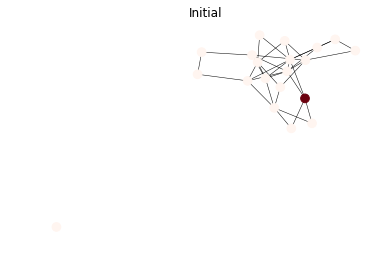

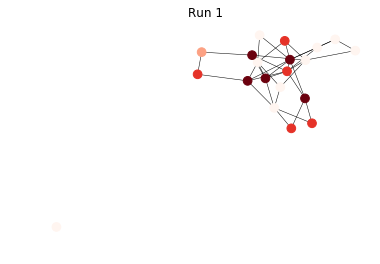

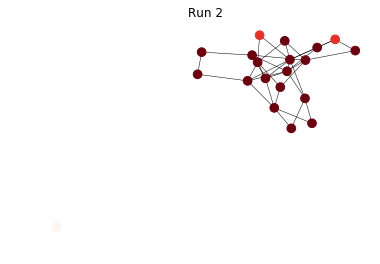

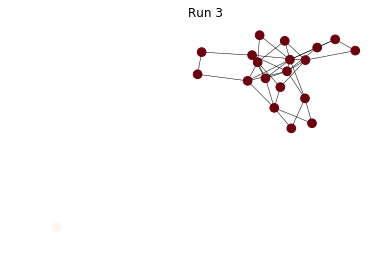

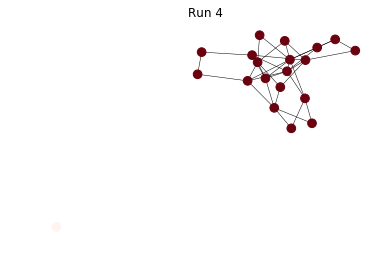

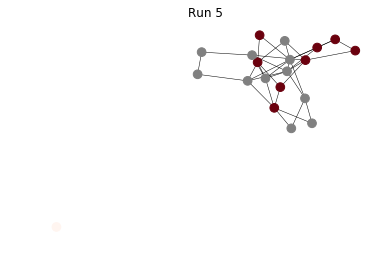

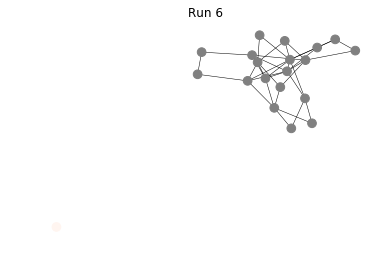

In [27]:
n = 20
g = random_network(n,0.15)
# #sus_dict = {i:(i+0.1)/n for i in range(n)}

# n = 10
# g = nx.complete_graph(n)

#g = nx.karate_club_graph()
#g = nx.balanced_tree(3,3)
#g = nx.relaxed_caveman_graph(3, 10,0.01)

# m, n = 5,5
# g0 = nx.grid_2d_graph(m, n)
# g = nx.convert_node_labels_to_integers(g0)

n_runs = 20
init_infect = 1

beta = 1
duration = 3
#duration = np.inf   # for SI, no recorvery
lethality = 3
run_sim(g,beta,duration,n_runs,lethality,init_infect)